In [30]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

import numpy as np
from random import random, uniform, randrange, triangular

In [227]:
from importlib import reload
import sys

from system import *
reload(sys.modules['system'])
from system import *

In [146]:
time = 1000
def get_sample():
    controller = x_controller()
    x = np.zeros((time,), dtype=np.float32)
    cmd = np.zeros((time,), dtype=np.float32)
    x_ddot = np.zeros((time,), dtype=np.float32)
    a = 0
    dt = 20
    lpf_a = 0
    
    px = [randrange(time) for _ in range(100)]
    py = [triangular(-1, 1) for _ in range(100)]
    py[0]=0
    px.sort()
    for i in range(time):
        a = interp(i, px, py)
        lpf_a = (1-1/dt)*lpf_a+(1/dt)*a
        controller.step(lpf_a)
        x[i] = controller.x
        cmd[i] = lpf_a
        x_ddot[i]=controller.x_ddot
    return x, cmd, x_ddot

def sample_generator():
    while True:
        yield get_sample()

Now the output is quite rate limited, and the samples are collected a bit differently. Let's see if the model can still learn

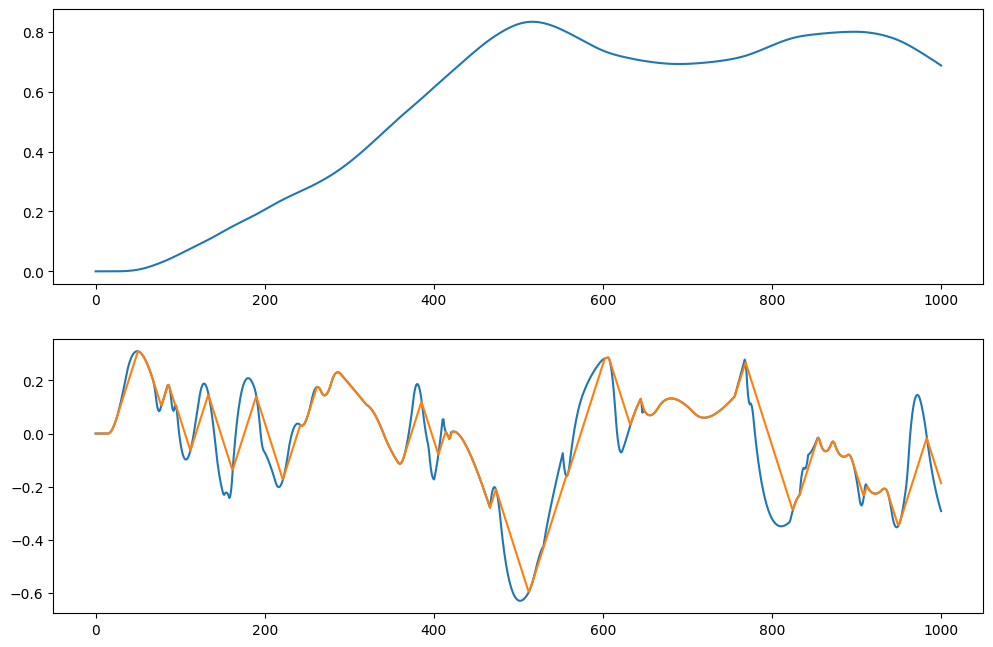

In [164]:
gen = sample_generator()
x, cmd, x_ddot = next(gen)
_, axs = plt.subplots(2)
axs[0].plot(np.linspace(0, time, time), x)
axs[1].plot(np.linspace(0, time, time), cmd)
axs[1].plot(np.linspace(0, time, time), x_ddot)


In [108]:
#Pytorch imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [117]:
class SimDataset(Dataset):
    def __init__(self, length, i, o):
        self.len = length
        self.i = i
        self.o = o

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.i[idx], self.o[idx]

In [235]:
generator = sample_generator()
#End at 750 to get reasonable probability of output clamping
def random_data_dataset(length):
    i_data = []
    o_data = []
    for i in range(length):
        if i%(length//10) == 0:
            print(f"{i}/{length}")
        data = next(generator)
        x = data[0]
        cmd = data[1]
        #data[2] so skrivni podatki
        data_input = np.concatenate((x[500:700], cmd[500:800]))
        data_output = np.zeros((1,), dtype=np.float32)
        data_output[0]=x[799]
        i_data.append(data_input)
        o_data.append(data_output)
    return SimDataset(length, i_data, o_data)


in_set = random_data_dataset(30000)
out_set = random_data_dataset(1000)

0/30000
3000/30000
6000/30000
9000/30000
12000/30000
15000/30000
18000/30000
21000/30000
24000/30000
27000/30000
0/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


In [236]:
train_dataloader = DataLoader(in_set, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(out_set, batch_size=64, shuffle=False)

In [252]:
def train_loop(dataloader, model, loss_fn, optimizer, debug):
    size = len(dataloader.dataset)
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if debug:
        loss = loss.item()
        print(f"Train loss: {loss:>10f}")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test  loss: {test_loss:>10f} \n")

model = NeuralNetwork()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [253]:
epochs = 100
print(len(train_dataloader))
print(len(test_dataloader))
for t in range(epochs):
    if t%10 == 0:
        print(f"Epoch {t}")
    train_loop(train_dataloader, model, loss_fn, optimizer, t%10==0)
    if t%10 == 0:m
        test_loop(test_dataloader, model, loss_fn)

468
16
Epoch 0
Train loss:   0.258228
Test  loss:   0.264871 

Epoch 10
Train loss:   0.008576
Test  loss:   0.010122 

Epoch 20
Train loss:   0.004795
Test  loss:   0.005062 

Epoch 30
Train loss:   0.004092
Test  loss:   0.003967 

Epoch 40
Train loss:   0.002861
Test  loss:   0.003297 

Epoch 50
Train loss:   0.002984
Test  loss:   0.002739 

Epoch 60
Train loss:   0.003620
Test  loss:   0.002220 

Epoch 70
Train loss:   0.001405
Test  loss:   0.001841 

Epoch 80
Train loss:   0.001007
Test  loss:   0.001557 

Epoch 90
Train loss:   0.001621
Test  loss:   0.001345 



Good losses, time for testing

-1.0
-0.9842106699943542 0.0002493029420271853


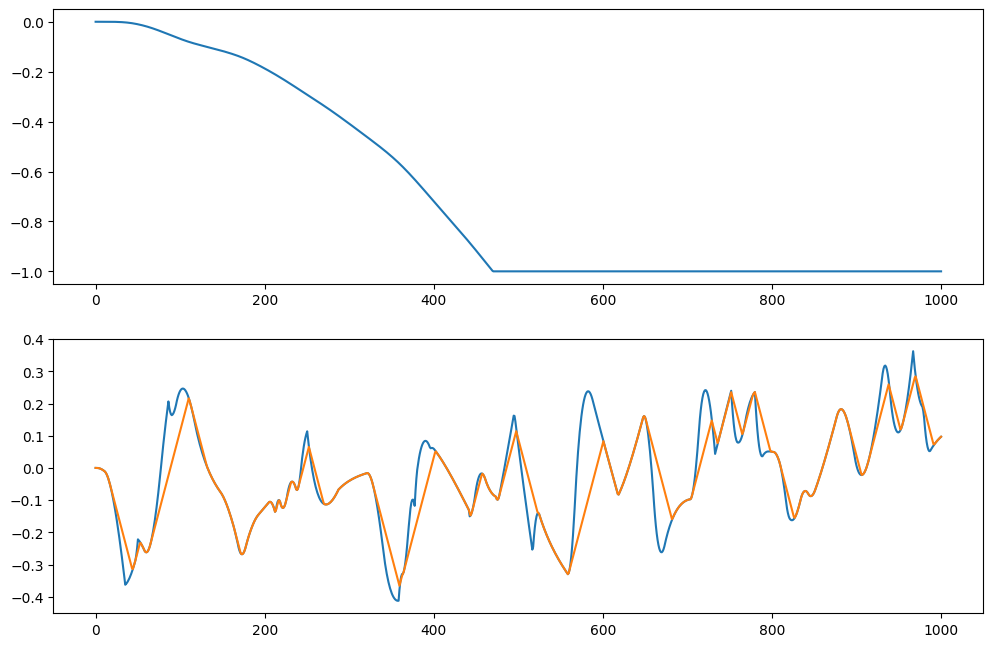

In [254]:
gen = sample_generator()
x, cmd, x_ddot = next(gen)
_, axs = plt.subplots(2)
axs[0].plot(np.linspace(0, time, time), x)
axs[1].plot(np.linspace(0, time, time), cmd)
axs[1].plot(np.linspace(0, time, time), x_ddot)

data_input = np.concatenate((x[500:700], cmd[500:800]))
torch_data_input = torch.from_numpy(data_input)
ans = x[799]
resp = model(torch_data_input).item()
print(ans)
print(resp, (resp-ans)**2)

Ok this model can deal with the output torque being delayed, quite insane... Let's do a tiny test just to be sure it's any good

0.12268
0.1266670674085617 1.5896698858652858e-05


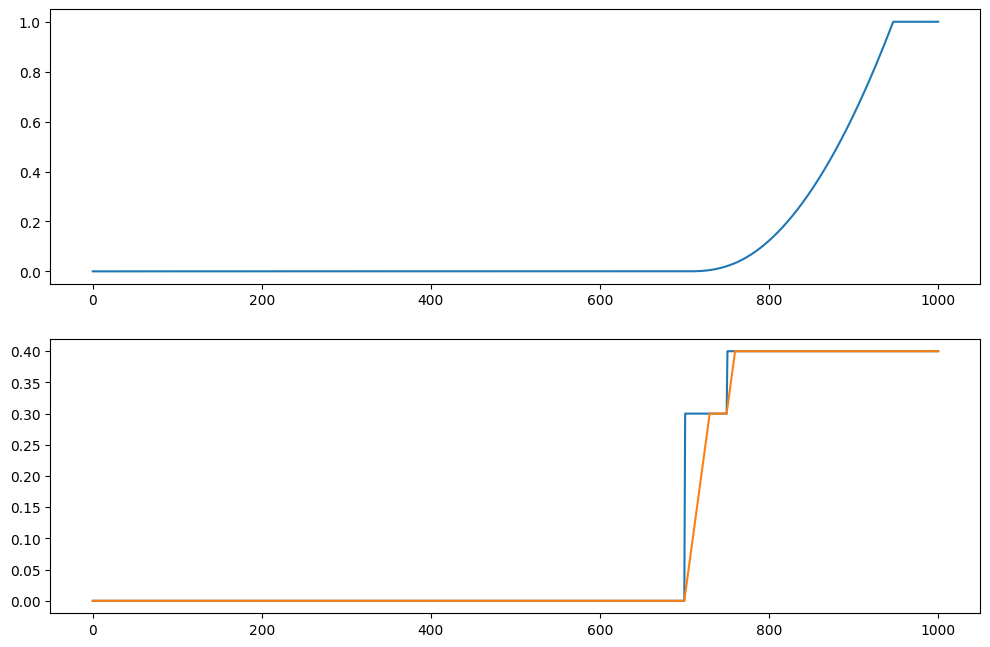

In [263]:
controller = x_controller()
x = np.zeros((time,), dtype=np.float32)
cmd = np.zeros((time,), dtype=np.float32)
x_ddot = np.zeros((time,), dtype=np.float32)
a = 0
for i in range(time):
    a = 0 if i<700 else (0.3 if i < 750 else 0.4)
    controller.step(a)
    x[i] = controller.x
    cmd[i] = a
    x_ddot[i] = controller.x_ddot

_, axs = plt.subplots(2)
axs[0].plot(np.linspace(0, time, time), x)
axs[1].plot(np.linspace(0, time, time), cmd)
axs[1].plot(np.linspace(0, time, time), x_ddot)

data_input = np.concatenate((x[500:700], cmd[500:800]))
torch_data_input = torch.from_numpy(data_input)

ans = x[799]
resp = model(torch_data_input).item()

print(ans)
print(resp, (resp-ans)**2)